In [1]:
## Import libraries
import numpy as np
import pandas as pd
import glob
from PIL import Image
from matplotlib.pyplot import imshow
import keras
from keras import layers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D,BatchNormalization
from tensorflow.keras import losses
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import Model

## Make function to load images, labels and paths
def get_images(path,resize = True):  
    img_array = []
    label_array=[]
    img_paths=[]
    fpaths = glob.glob(path, recursive=True)
    
    for fname in fpaths:
        img = Image.open(fname).convert('L')
        if(resize): img = img.resize((64,64))
        img_array.append(np.asarray(img))
        img_paths.append(fname)
        
        if 'good' in fname:
            label_array.append(0)
        else:
            label_array.append(1)
            
    paths=np.array(img_paths)
    images = np.array(img_array)
    labels= np.array(label_array)
    return images,labels,paths

In [2]:
## Import images from the local path.
path_train = r"C:/Users/polit/OneDrive/Desktop/MVtec/bottle2/train/**/*.*"
path_test = r"C:/Users/polit/OneDrive/Desktop/MVtec/bottle2/test/**/*.*"
path_cont_test = r"C:/Users/polit/OneDrive/Desktop/MVtec/bottle2/test/contamination/*.*"
path_broken_large_test = r"C:/Users/polit/OneDrive/Desktop/MVtec/bottle2/test/broken_large/*.*"

all_train,train_labels ,train_paths= get_images(path_train)
test ,test_labels,test_paths= get_images(path_test)
cont_test ,cont_test_labels,cont_test_paths= get_images(path_cont_test)
broken_large_test ,broken_large_test_labels,broken_large_test_paths= get_images(path_broken_large_test)

# Normalize image data
all_train = all_train.astype('float32') /255.
test = test.astype('float32') / 255.
cont_test = cont_test.astype('float32') / 255.
broken_large_test = broken_large_test.astype('float32') / 255.

# Split images for training and validation and Prepare for the variational autoencoder model
(train, val) = train_test_split(all_train, shuffle=False, train_size=0.8, random_state=1)
train = train.reshape(train.shape[0], train.shape[1], train.shape[2], 1)
val = val.reshape(val.shape[0], val.shape[1], val.shape[2], 1)
test = test.reshape(test.shape[0], test.shape[1], test.shape[2], 1)
cont_test = cont_test.reshape(cont_test.shape[0], cont_test.shape[1], cont_test.shape[2], 1)
broken_large_test = broken_large_test.reshape(broken_large_test.shape[0], broken_large_test.shape[1], broken_large_test.shape[2], 1)

In [5]:
# Lets define our autoencoder model.
def autoencoder_model():
    
    
    channels = 1  # we have used grayscale images

   # Encoder ----------
    input_img = keras.Input(train[0].shape)
    x = keras.layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(input_img)
    x = keras.layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(x)
    x = keras.layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(x)
    x = keras.layers.Conv2D(32, (3, 3), strides=1, activation="relu", padding="same")(x)
    x = keras.layers.Conv2D(64, (4, 4), strides=2, activation="relu", padding="same")(x)
    x = keras.layers.Conv2D(64, (3, 3), strides=1, activation="relu", padding="same")(x)
    x = keras.layers.Conv2D(128, (4, 4), strides=2, activation="relu", padding="same")(x)
    x = keras.layers.Conv2D(64, (3, 3), strides=1, activation="relu", padding="same")(x)
    x = keras.layers.Conv2D(32, (3, 3), strides=1, activation="relu", padding="same")(x)
    encoded = keras.layers.Conv2D(1, (8, 8), strides=1, padding="same")(x)

    # Decoder----------
    x = keras.layers.Conv2D(32, (3, 3), strides=1, activation="relu", padding="same")(encoded)
    x = keras.layers.Conv2D(64, (3, 3), strides=1, activation="relu", padding="same")(x)
    x = keras.layers.UpSampling2D((2, 2))(x)
    x = keras.layers.Conv2D(128, (4, 4), strides=2, activation="relu", padding="same")(x)
    x = keras.layers.UpSampling2D((2, 2))(x)
    x = keras.layers.Conv2D(64, (3, 3), strides=1, activation="relu", padding="same")(x)
    x = keras.layers.UpSampling2D((2, 2))(x)
    x = keras.layers.Conv2D(64, (4, 4), strides=2, activation="relu", padding="same")(x)
    x = keras.layers.UpSampling2D((2, 2))(x)
    x = keras.layers.Conv2D(32, (3, 3), strides=1, activation="relu", padding="same")(x)
    x = keras.layers.UpSampling2D((2, 2))(x)
    x = keras.layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(x)
    x = keras.layers.UpSampling2D((4, 4))(x)
    x = keras.layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(x)
    x = keras.layers.UpSampling2D((2, 2))(x)
    x = keras.layers.Conv2D(32, (8, 8), activation="relu", padding="same")(x)

    x = keras.layers.UpSampling2D((2, 2))(x)
    decoded = keras.layers.Conv2D(
        channels, (8, 8), activation="sigmoid", padding="same")(x)
    autoencoder = keras.Model(input_img, decoded)
    print(autoencoder.summary())
    return autoencoder

In [6]:
# compile the model and check model summary
autoencoder =autoencoder_model()
# autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])
autoencoder.compile(optimizer=keras.optimizers.Adam(lr=1e-3), loss='mse',metrics=['mae'])
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        544       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        16416     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 32)          16416     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 64)          32832     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 64)         

In [7]:
# Train the model

learned_weights = ModelCheckpoint(filepath = 'C:/Users/polit/OneDrive/Desktop/MVtec/mvtec.hdf5', verbose = 2, save_best_only = True)


nb_epochs = 50
batch_size = 32
autoencoder_train = autoencoder.fit(train, train, epochs=nb_epochs, batch_size=batch_size,
                    validation_data=(val,val),callbacks = [learned_weights])

Epoch 1/50
147/147 [==============================] - ETA: 0s - loss: 0.0300 - mae: 0.1097
Epoch 00001: val_loss improved from inf to 0.00431, saving model to C:/Users/polit/OneDrive/Desktop/MVtec\mvtec.hdf5
147/147 [==============================] - 122s 833ms/step - loss: 0.0300 - mae: 0.1097 - val_loss: 0.0043 - val_mae: 0.0398
Epoch 2/50
147/147 [==============================] - ETA: 0s - loss: 0.0042 - mae: 0.0384
Epoch 00002: val_loss improved from 0.00431 to 0.00354, saving model to C:/Users/polit/OneDrive/Desktop/MVtec\mvtec.hdf5
147/147 [==============================] - 122s 833ms/step - loss: 0.0042 - mae: 0.0384 - val_loss: 0.0035 - val_mae: 0.0358
Epoch 3/50
147/147 [==============================] - ETA: 0s - loss: 0.0039 - mae: 0.0364
Epoch 00003: val_loss did not improve from 0.00354
147/147 [==============================] - 123s 838ms/step - loss: 0.0039 - mae: 0.0364 - val_loss: 0.0040 - val_mae: 0.0355
Epoch 4/50
147/147 [==============================] - ETA: 0s -

147/147 [==============================] - ETA: 0s - loss: 0.0016 - mae: 0.0227
Epoch 00027: val_loss improved from 0.00171 to 0.00160, saving model to C:/Users/polit/OneDrive/Desktop/MVtec\mvtec.hdf5
147/147 [==============================] - 135s 921ms/step - loss: 0.0016 - mae: 0.0227 - val_loss: 0.0016 - val_mae: 0.0223
Epoch 28/50
147/147 [==============================] - ETA: 0s - loss: 0.0016 - mae: 0.0226
Epoch 00028: val_loss improved from 0.00160 to 0.00153, saving model to C:/Users/polit/OneDrive/Desktop/MVtec\mvtec.hdf5
147/147 [==============================] - 140s 952ms/step - loss: 0.0016 - mae: 0.0226 - val_loss: 0.0015 - val_mae: 0.0220
Epoch 29/50
147/147 [==============================] - ETA: 0s - loss: 0.0016 - mae: 0.0223
Epoch 00029: val_loss did not improve from 0.00153
147/147 [==============================] - 131s 892ms/step - loss: 0.0016 - mae: 0.0223 - val_loss: 0.0015 - val_mae: 0.0219
Epoch 30/50
147/147 [==============================] - ETA: 0s - los

In [8]:

from keras.models import load_model

img_row, img_height, img_depth = 32,32,3
autoencoder1 = load_model('C:/Users/polit/OneDrive/Desktop/MVtec/mvtec.hdf5')

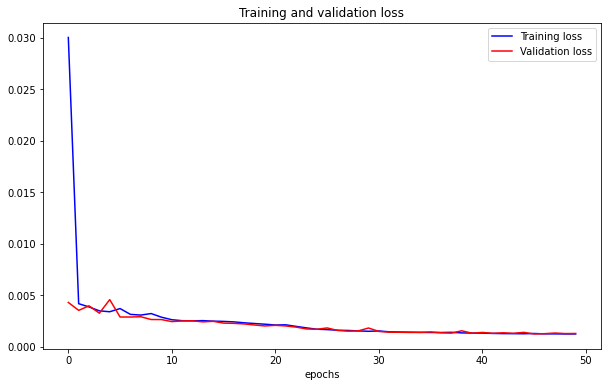

In [30]:
## Lets plot training loss ,mae and validation loss
x=range(nb_epochs)
loss = autoencoder_train.history['loss']
# mae = autoencoder_train.history['mae']
# val_mae = autoencoder_train.history['val_mae']
val_loss = autoencoder_train.history['val_loss']
plt.figure(figsize=(10,6))
# plt.plot(x, mae, 'b:', label='mae')
# plt.plot(x, val_mae, 'r:', label='Validation mae')
plt.plot(x, loss, 'b', label='Training loss')
plt.plot(x, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [31]:
# Define a function which calculates mean square error
def get_error(imgs_true, imgs_pred):
    return np.square(np.subtract(imgs_true, imgs_pred)).mean()
    
## Lets make empty lists to store mse for training, test and reconstruction images.          
train_pred = autoencoder1.predict(train)
mse_vector=[]
mse_vector_test=[]
mse_vector_cont_test=[]
mse_vector_broken_large_test = []
for i in range(train.shape[0]):
    mse_vector.append( get_error(train_pred[i], train[i]))

    
# Let us define the threshold value, below which images are normal and 
# after which images are anomaly
    
# threshold = np.quantile(mse_vector, 0.9)
# threshold = np.mean(mse_vector)+np.std(mse_vector)
threshold = np.mean(mse_vector)

test_pred = autoencoder1.predict(test)
cont_test_pred = autoencoder1.predict(cont_test)
broken_large_test_pred = autoencoder1.predict(broken_large_test)

for i in range(test.shape[0]):
    mse_vector_test.append( get_error(test_pred[i], test[i]))
test_anomaly = (mse_vector_test > threshold)
print(test_anomaly)

for i in range(cont_test.shape[0]):
    mse_vector_cont_test.append( get_error(cont_test_pred[i], cont_test[i]))
cont_test_anomaly = (mse_vector_cont_test > threshold)
print('cont_test_anomaly',cont_test_anomaly)

for i in range(broken_large_test.shape[0]):
    mse_vector_broken_large_test.append( get_error(broken_large_test_pred[i], broken_large_test[i]))
broken_large_test_anomaly = (mse_vector_broken_large_test > threshold)
print( '\n broken_large_test_anomaly',broken_large_test_anomaly)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False False False False False False False False False
 False False False False  True False False  True False False  True]
cont_test_anomaly [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]

 broken_large_test_anomaly [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


In [32]:
a = max(mse_vector)

b = min(mse_vector)
c = np.mean(mse_vector)
 

print('maximum value of mse vector is ', a, 'and minimum value is ', b, 'mean value is ', c)


maximum value of mse vector is  0.0033056901 and minimum value is  0.00048479502 mean value is  0.0012150849


(array([2.170e+02, 1.414e+03, 1.596e+03, 9.510e+02, 3.470e+02, 1.070e+02,
        4.500e+01, 1.200e+01, 4.000e+00, 1.000e+00]),
 array([0.0004848 , 0.00076688, 0.00104897, 0.00133106, 0.00161315,
        0.00189524, 0.00217733, 0.00245942, 0.00274151, 0.0030236 ,
        0.00330569], dtype=float32),
 <BarContainer object of 10 artists>)

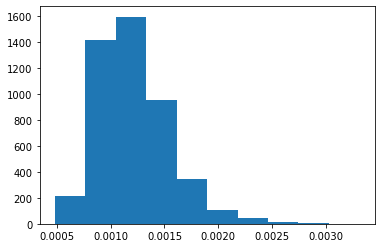

In [33]:
# Plot mse vector for normal images
plt.hist(mse_vector)

(array([25., 17., 21., 10.,  6.,  2.,  1.,  0.,  0.,  1.]),
 array([0.00065364, 0.00151597, 0.00237831, 0.00324065, 0.00410299,
        0.00496532, 0.00582766, 0.00669   , 0.00755233, 0.00841467,
        0.00927701], dtype=float32),
 <BarContainer object of 10 artists>)

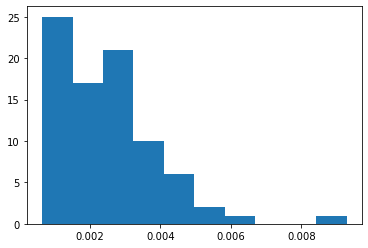

In [34]:
# Plot mse vector for test images
plt.hist(mse_vector_test)

(array([3., 5., 3., 5., 2., 1., 1., 0., 0., 1.]),
 array([0.00123782, 0.00204174, 0.00284566, 0.00364957, 0.00445349,
        0.00525741, 0.00606133, 0.00686525, 0.00766917, 0.00847309,
        0.00927701], dtype=float32),
 <BarContainer object of 10 artists>)

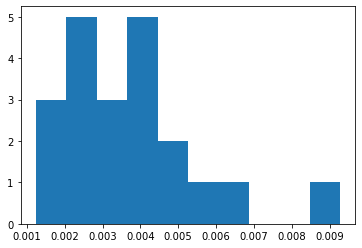

In [35]:
# Plot mse vector for contaminated images
plt.hist(mse_vector_cont_test)


(array([3., 2., 2., 3., 2., 2., 0., 3., 2., 1.]),
 array([0.00139317, 0.00168742, 0.00198167, 0.00227592, 0.00257017,
        0.00286442, 0.00315866, 0.00345291, 0.00374716, 0.00404141,
        0.00433566], dtype=float32),
 <BarContainer object of 10 artists>)

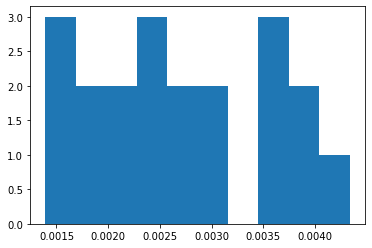

In [36]:
# Plot mse vector for broken large images
plt.hist(mse_vector_broken_large_test)

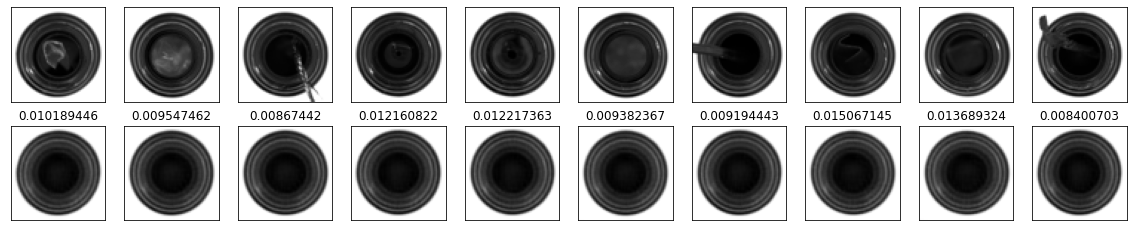

In [37]:
# Plot original and decoded images
decoded_imgs = autoencoder.predict(cont_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(cont_test[i].reshape(64,64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(64,64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(get_error(decoded_imgs[i], test[i]))
plt.show()


In [38]:
# Accuracy of our model with test images

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report,confusion_matrix
print("Accuracy = {}".format(accuracy_score(test_labels, test_anomaly)))
print("Precision = {}".format(precision_score(test_labels, test_anomaly)))
print("Recall = {}".format(recall_score(test_labels, test_anomaly)))
print( classification_report(test_labels, test_anomaly))

Accuracy = 0.9518072289156626
Precision = 0.9538461538461539
Recall = 0.9841269841269841
              precision    recall  f1-score   support

           0       0.94      0.85      0.89        20
           1       0.95      0.98      0.97        63

    accuracy                           0.95        83
   macro avg       0.95      0.92      0.93        83
weighted avg       0.95      0.95      0.95        83



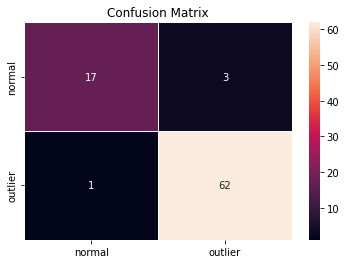

In [39]:
import seaborn as sns
labels = ['normal', 'outlier']
cm = confusion_matrix(test_labels, test_anomaly)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True,  cbar=True, linewidths=1)
plt.title("Confusion Matrix")
labels = ['normal', 'outlier']

In [40]:
# Accuracy of our model with contaminated images

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report
print("Accuracy = {}".format(accuracy_score(cont_test_labels, cont_test_anomaly)))
print("Precision = {}".format(precision_score(cont_test_labels, cont_test_anomaly)))
print("Recall = {}".format(recall_score(cont_test_labels, cont_test_anomaly)))
print( classification_report(cont_test_labels, cont_test_anomaly))

Accuracy = 1.0
Precision = 1.0
Recall = 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        21

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



In [41]:
# Accuracy of our model with broken large images

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report
print("Accuracy = {}".format(accuracy_score(broken_large_test_labels, broken_large_test_anomaly)))
print("Precision = {}".format(precision_score(broken_large_test_labels, broken_large_test_anomaly)))
print("Recall = {}".format(recall_score(broken_large_test_labels, broken_large_test_anomaly)))
print( classification_report(broken_large_test_labels, broken_large_test_anomaly))

Accuracy = 1.0
Precision = 1.0
Recall = 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        20

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [42]:
# Make empty list of threshold value and store different values.
threshold_value = []
threshold1 = np.mean(mse_vector)
for i in range(0,20,2):
    threshold2 = threshold1 + i*0.05*np.std(mse_vector)
    threshold_value.append(threshold2)

# Check threshold values
threshold_value

[0.0012150849215686321,
 0.001248061200021766,
 0.0012810374784749002,
 0.001314013756928034,
 0.0013469900353811682,
 0.0013799663138343021,
 0.001412942592287436,
 0.0014459188707405702,
 0.001478895149193704,
 0.0015118714276468382]

In [43]:
# Make empty list of accuracy and append with accuries obtained by using different threshold values.
total_accuracy = []

for x in threshold_value:
    test_anomaly = (mse_vector_test > x)
    accuracy = accuracy_score(test_labels, test_anomaly)
    total_accuracy.append(accuracy)
    
# Check accuracies
total_accuracy

[0.9518072289156626,
 0.9397590361445783,
 0.927710843373494,
 0.9036144578313253,
 0.9156626506024096,
 0.9156626506024096,
 0.9156626506024096,
 0.9156626506024096,
 0.9156626506024096,
 0.9156626506024096]

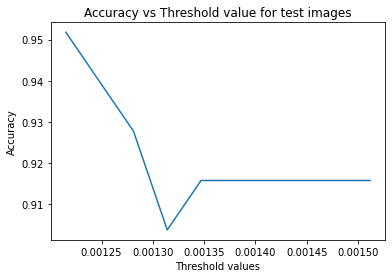

In [44]:
# Plot accuracy and threshold values
plt.plot(threshold_value, total_accuracy)
plt.title("Accuracy vs Threshold value for test images")
plt.xlabel("Threshold values")
plt.ylabel("Accuracy")
plt.show()

In [45]:
# Check accuracy for contaminated images
total_accuracy1 = []

for x in threshold_value:
    test_anomaly1 = (mse_vector_cont_test > x)
    accuracy1 = accuracy_score(cont_test_labels, test_anomaly1)
    total_accuracy1.append(accuracy1)

# Accurecies for different threshold values.
total_accuracy1

[1.0,
 0.9523809523809523,
 0.9047619047619048,
 0.9047619047619048,
 0.9047619047619048,
 0.9047619047619048,
 0.9047619047619048,
 0.9047619047619048,
 0.9047619047619048,
 0.9047619047619048]

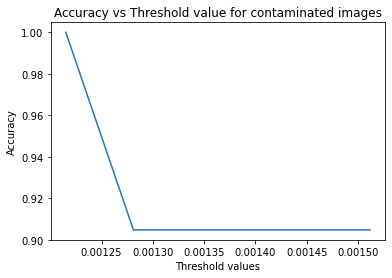

In [46]:
import matplotlib.pyplot as plt
plt.plot(threshold_value, total_accuracy1)
plt.title("Accuracy vs Threshold value for contaminated images")
plt.xlabel("Threshold values")
plt.ylabel("Accuracy")
plt.show()

In [47]:
# Check accuracy for broken large images
total_accuracy2 = []

for x in threshold_value:
    test_anomaly2 = (mse_vector_broken_large_test > x)
    accuracy2 = accuracy_score(broken_large_test_labels, test_anomaly2)
    total_accuracy2.append(accuracy2)

# Accurecies for different threshold values.
total_accuracy2

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 0.95, 0.95, 0.95]

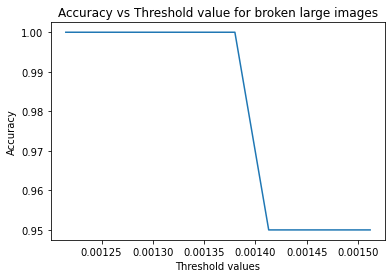

In [48]:
import matplotlib.pyplot as plt
plt.plot(threshold_value, total_accuracy2)
plt.title("Accuracy vs Threshold value for broken large images")
plt.xlabel("Threshold values")
plt.ylabel("Accuracy")
plt.show()